# Прогнозирование толерантности к риску и оптимизация инвестиционного портфеля 

Цели данной работы: 
- Получить данные по котировкам заданных финансовых инструментов используя библиотеку yfinance;
- На основе данных из опроса потребительских финансов Совета управляющих ФРС США рассчитать толерантность к риску инвесторов;
- Подобрать модель, которая будет предсказывать толерантность к риску инвестора на основе демографических данных и данных о доходе;
- Написать приложение, которое будет подбирать и отображать оптимальный портфель на основе созданной модели и портфельной теории Марковица. 

# 1. Постановка задачи

Для задачи определения уровня терпимости к риску инвестора будет использован опрос потребительских финансов (англ. Survey of Consumer Finances (SCF)). Опрос был проведен Советом управляющих Федеральной резервной системы США в 2007 и 2009 году на постоянной выборке индивидов. Именно этот период был выбран в связи с тем, что исследование проводились до и после финансового кризиса 2007-2008 годов соответственно. Таким образом, сравнивая данные 2007 года и 2009 года, можно исключить то влияние, которое изменение экономической конъюнктуры имело на инвестиционную стратегию индивидов. 
Источник данных: 
https://www.federalreserve.gov/econres/scf_2009p.htm

<a id='1'></a>
# 2. Подготовка данных 

<a id='1.1'></a>
## 2.1. Импорт библиотек 

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

<a id='1.2'></a>
## 2.2. Загрузка датасета  

In [2]:
dataset = pd.read_excel('SCFP2009panel.xlsx')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

In [5]:
dataset.shape

(19285, 515)

In [6]:
dataset.isna().sum().sum()

0

In [7]:
print('Null Values =',dataset.isnull().values.any())

Null Values = False


<a id='2.1'></a>
## 2.3. Расчет прогнозируемой переменной 

Прогнозируемая переменная - это терпимость к риску индивида. Вычисление прогнозируемой терпимости к риску проводится следующим образом:
1) Производится расчет рисковых актив и безрисковых активов для всех опрошенных лиц. Рисковые и безрисковые активы определяются следующим образом:
- Рисковые активы — это инвестиции в паевые инвестиционные фонды, акции, облигации, товары и недвижимость, а также человеческий капитал. 
- Безрисковые активы — чековые и сберегательные остатки, депозитные сертификаты и другие денежные остатки и их эквиваленты.

2) Рассчитывается отношение объема рисковых активов к общим активам инвестора. Данное отношение, нормализованное средним значением стоимости акций в 2007 и 2009 году соответственно, рассматривается как мера терпимости инвестора к риску.  Таким образом, признаки RT07 и RT09 определены как отношение рискованных активов к безрисковым активам, нормализованное средним значением фондового индекса Standard and Poor's 500 (S&P 500) за 2007 г. по сравнению с 2009 г. Среднее значение S&P 500 в 2007 г.: 1478 долларов США. Среднее значение S&P 500 в 2009 г.: 948 долларов США. Таким образом, индекс S&P 500  выступает как индекс-дефлятор, что позволяет отобразить динамику объема активов без учета изменения цен.

3) Из литературы следует, что разумным инвестором считается тот, кто имеет последовательную инвестиционную стратегию и не меняет уровень риска своего портфеля при изменении рыночной конъюнктуры. Таким образом, в выборке остаются инвесторы, которые изменили свою толерантность к риску менее чем на 10% в период с 2007 по 2009 год. Таким образом данные возможно частично очистить от колебаний в активах в связи с изменением в экономической конъюнктуре. 

In [8]:
Average_SP500_2007=1478
Average_SP500_2009=948

dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

In [9]:
dataset2 = copy.deepcopy(dataset)  
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09
0,1,11,11668.134198,47,3,12,2,1,0,2,...,0.0,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422
1,1,12,11823.456494,47,3,12,2,1,0,2,...,0.0,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036
2,1,13,11913.228354,47,3,12,2,1,0,2,...,0.0,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876
3,1,14,11929.394266,47,3,12,2,1,0,2,...,0.0,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429
4,1,15,11917.722907,47,3,12,2,1,0,2,...,0.0,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410


In [10]:
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)

In [11]:
print('Null Values =',dataset2.isnull().values.any())

Null Values = True


In [12]:
dataset2=dataset2.dropna(axis=0)

dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(1)]

print('Null Values =',dataset2.isnull().values.any())

Null Values = False


<AxesSubplot:xlabel='RT07'>

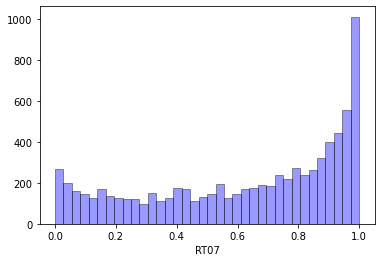

In [13]:
sns.distplot(dataset2['RT07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='RT09'>

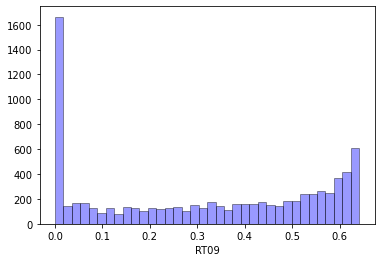

In [14]:
sns.distplot(dataset2['RT09'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [15]:
dataset3 = copy.deepcopy(dataset2)  

In [16]:
dataset3 = dataset3[dataset3['PercentageChange']<=.1]

In [17]:
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2

In [18]:
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

<a id='2.1'></a>
## 2.4. Определение назависимых переменных 

Независимыми переменными являются следующие демографические, финансовые и поведенческие характеристики: 
- AGE: Числовой признак, обозначающий возраст индивида.
- EDCL: Порядковый признак, обозначающий уровень образования. Данный признак представляет собой 4 категории образования, где значение 1 означает отсутствие аттестата об окончании средней школы, а значение 4 – степень бакалавра.
- MARRIED: Порядковый признак, обозначающий семейное положение. Значение 1 означает, что человек женат, а значение 2 – что он/она не состоит в браке.
- OCCAT2: Порядковый признак, обозначающий категорию занятости. Значение 1 соответствует управленческой роли, а значение 4 – статусу безработного.
- KIDS: Числовой признак, обозначающий количество детей.
- NETWORTH: Числовой признак, обозначающий объем собственного капитала. Рассчитывается как разница между объемом активов и долгами. 
- INCOME: Числовой признак, обозначающий объем дохода домохозяйства.
- RISK: Порядковый признак, обозначает готовность идти на риск по шкале от 1 до 4, где 1 представляет наивысший уровень готовности идти на риск.

In [19]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance'
]

drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

<a id='1'></a>
# 3. Разведочный анализ данных 

<AxesSubplot:xlabel='TrueRiskTolerance'>

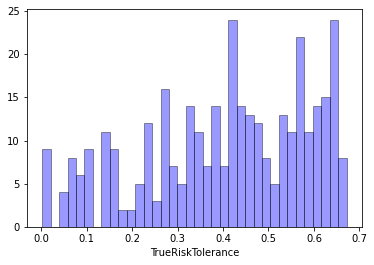

In [20]:
sns.distplot(dataset3['TrueRiskTolerance'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='AGE07'>

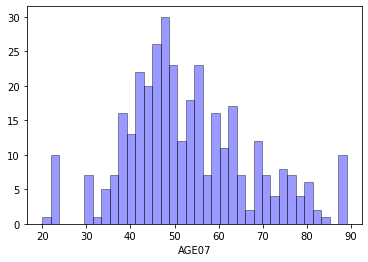

In [21]:
sns.distplot(dataset3['AGE07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='EDCL07'>

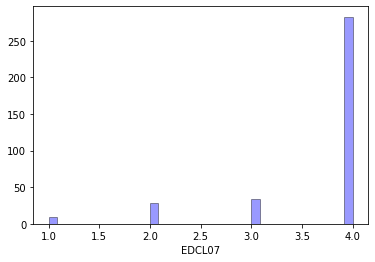

In [22]:
sns.distplot(dataset3['EDCL07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='MARRIED07'>

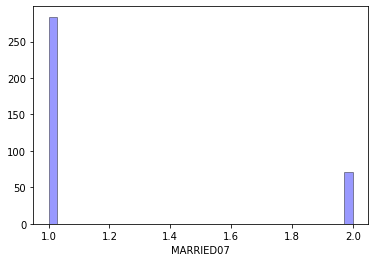

In [23]:
sns.distplot(dataset3['MARRIED07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='KIDS07'>

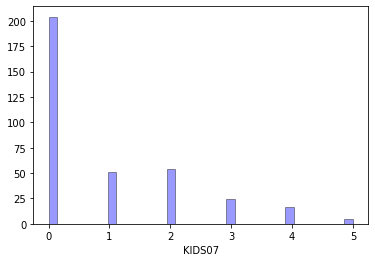

In [24]:
sns.distplot(dataset3['KIDS07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='OCCAT107'>

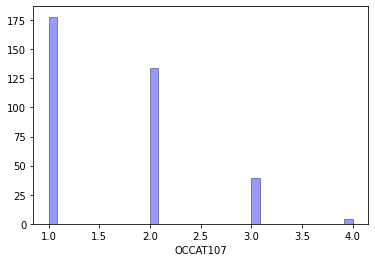

In [25]:
sns.distplot(dataset3['OCCAT107'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='INCOME07'>

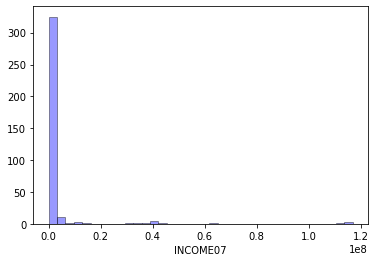

In [26]:
sns.distplot(dataset3['INCOME07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='RISK07'>

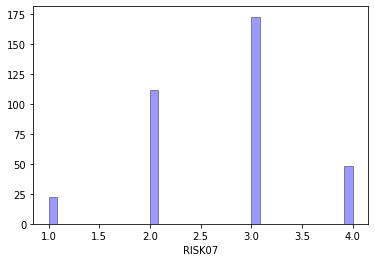

In [27]:
sns.distplot(dataset3['RISK07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='NETWORTH07'>

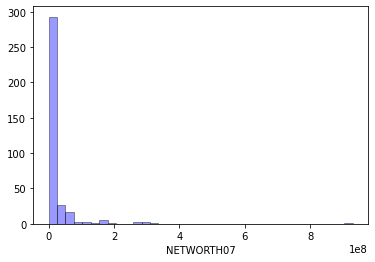

In [28]:
sns.distplot(dataset3['NETWORTH07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [29]:
dataset3

,AGE07,EDCL07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,NETWORTH07,TrueRiskTolerance
60,77,2,1,0,3,3.141680e+04,4,2.152490e+05,0.199511
425,55,4,1,1,2,2.779588e+06,2,4.964759e+07,0.641458
1122,85,4,1,0,2,3.727417e+05,4,5.837768e+07,0.589943
1190,40,2,1,3,1,5.324882e+04,3,2.688929e+05,0.434127
1228,70,2,1,0,2,3.716767e+04,3,2.015066e+06,0.228218
...,...,...,...,...,...,...,...,...,...
19190,53,4,1,0,1,1.810460e+05,2,7.580575e+05,0.352094
19191,53,4,1,0,1,1.821109e+05,2,7.570219e+05,0.357442
19192,53,4,1,0,1,1.810460e+05,2,7.580575e+05,0.352094
19193,53,4,1,0,1,1.810460e+05,2,7.580575e+05,0.352094


Let us look at the correlation among the features.

<AxesSubplot:title={'center':'Correlation Matrix'}>

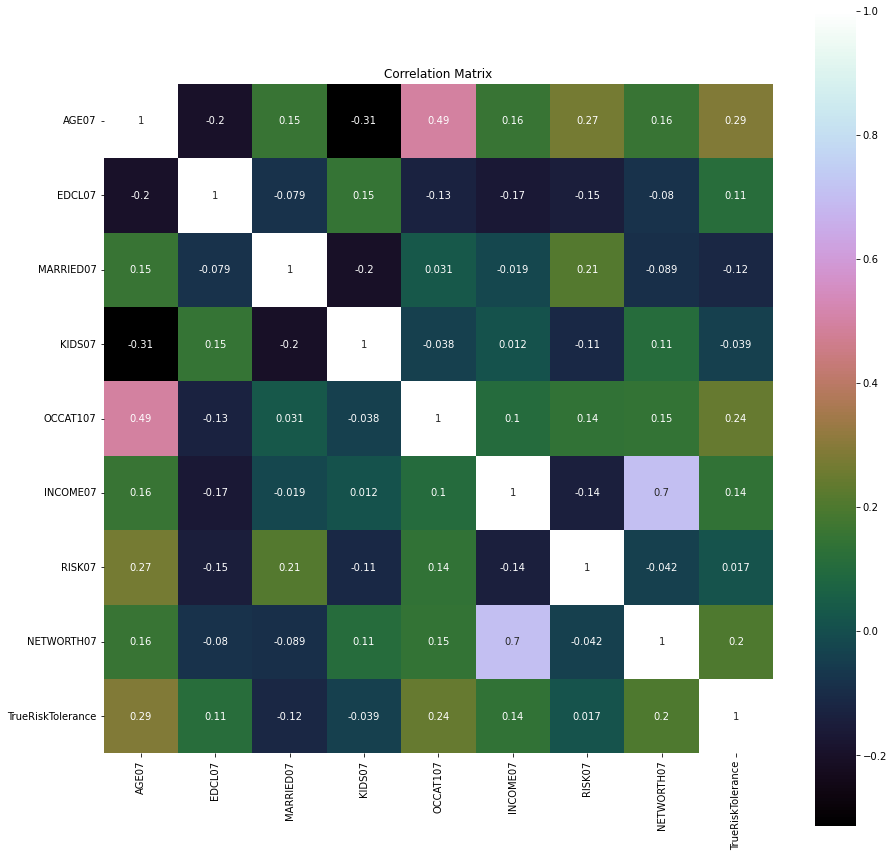

In [30]:
# correlation
correlation = dataset3.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

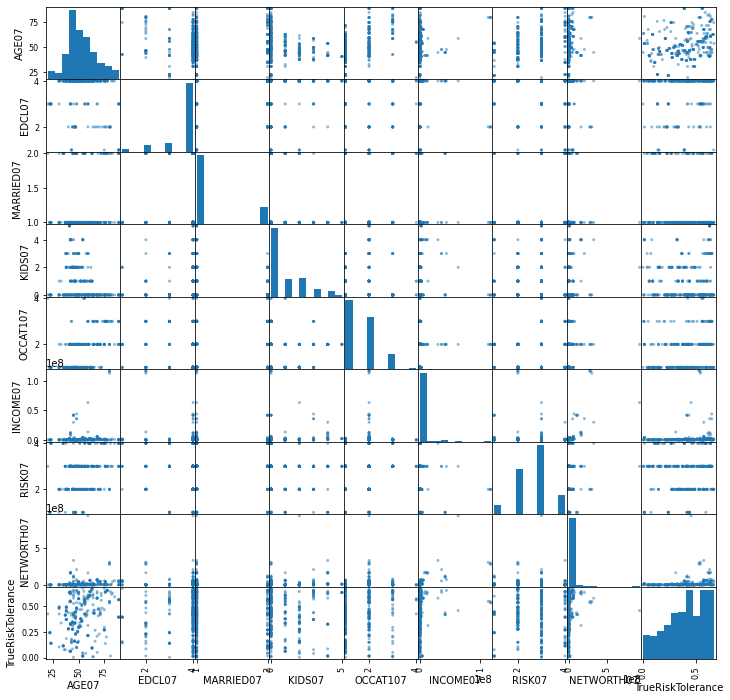

In [31]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15,15))
scatter_matrix(dataset3,figsize=(12,12))
plt.show()

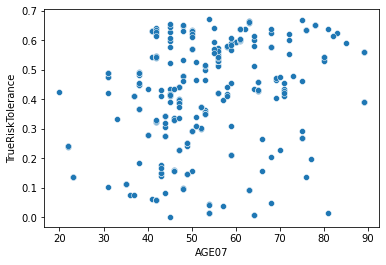

In [32]:
sns.scatterplot(x="AGE07", y="TrueRiskTolerance", data=dataset3);

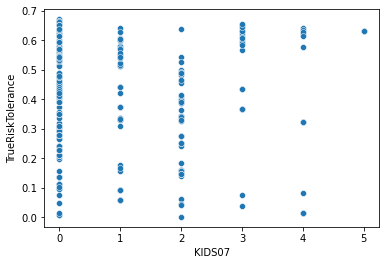

In [33]:
sns.scatterplot(x="KIDS07", y="TrueRiskTolerance", data=dataset3);

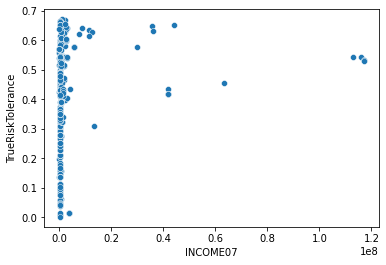

In [34]:
sns.scatterplot(x="INCOME07", y="TrueRiskTolerance", data=dataset3);

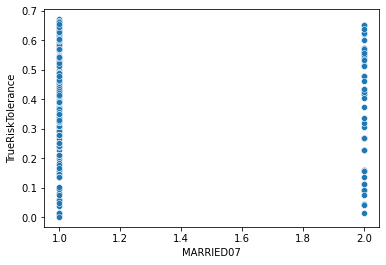

In [35]:
sns.scatterplot(x="MARRIED07", y="TrueRiskTolerance", data=dataset3);

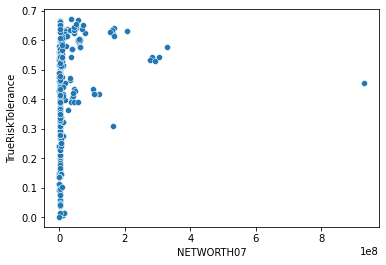

In [36]:
sns.scatterplot(x="NETWORTH07", y="TrueRiskTolerance", data=dataset3);

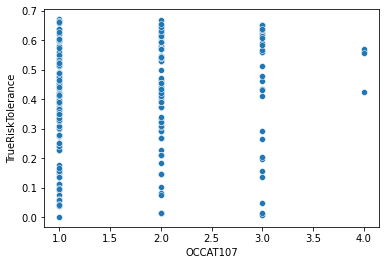

In [37]:
sns.scatterplot(x="OCCAT107", y="TrueRiskTolerance", data=dataset3);

In [38]:
correlations = dataset3.corrwith(dataset3['TrueRiskTolerance'])
correlations = correlations.drop('TrueRiskTolerance')
print(correlations)

AGE07         0.290022
EDCL07        0.113975
MARRIED07    -0.116096
KIDS07       -0.038783
OCCAT107      0.242642
INCOME07      0.139044
RISK07        0.017230
NETWORTH07    0.201585
dtype: float64


<a id='1'></a>
# 4. Нормализация данных   

In [39]:
x = dataset3.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset3 = pd.DataFrame(x_scaled, columns = ['AGE','EDCL', 'MARRIED','KIDS','OCCAT', 'INCOME', 'RISK','NETWORTH','TrueRiskTolerance'])

<AxesSubplot:xlabel='AGE'>

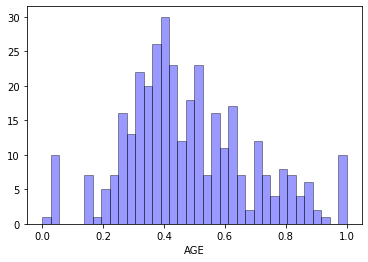

In [40]:
sns.distplot(dataset3['AGE'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='EDCL'>

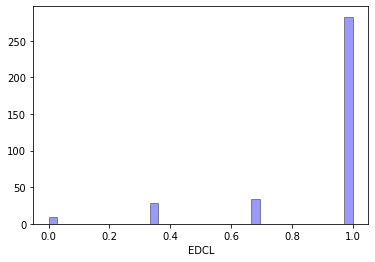

In [41]:
sns.distplot(dataset3['EDCL'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='MARRIED'>

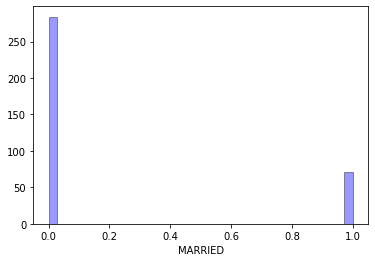

In [42]:
sns.distplot(dataset3['MARRIED'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='OCCAT'>

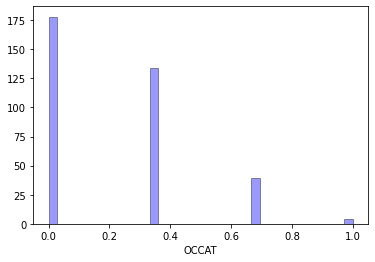

In [43]:
sns.distplot(dataset3['OCCAT'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='INCOME'>

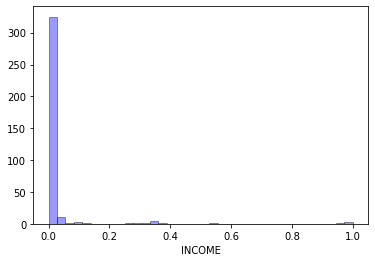

In [44]:
sns.distplot(dataset3['INCOME'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='KIDS'>

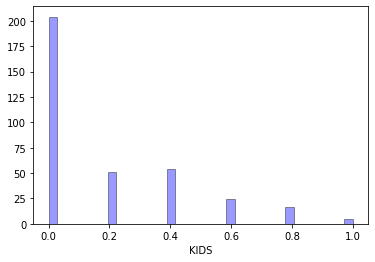

In [45]:
sns.distplot(dataset3['KIDS'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='RISK'>

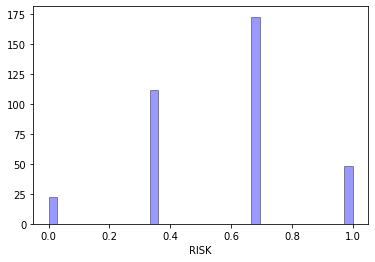

In [46]:
sns.distplot(dataset3['RISK'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='NETWORTH'>

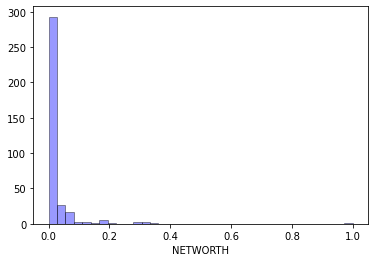

In [47]:
sns.distplot(dataset3['NETWORTH'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='TrueRiskTolerance'>

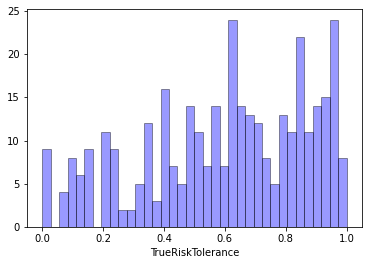

In [48]:
sns.distplot(dataset3['TrueRiskTolerance'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [49]:
dataset3.describe()

,AGE,EDCL,MARRIED,KIDS,OCCAT,INCOME,RISK,NETWORTH,TrueRiskTolerance
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,0.478955,0.888263,0.200000,0.182535,0.210329,0.026456,0.565258,0.021685,0.597633
std,0.206823,0.244917,0.400565,0.256947,0.240748,0.118175,0.259861,0.070826,0.271598
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.340580,1.000000,0.000000,0.000000,0.000000,0.000682,0.333333,0.000528,0.407262
50%,0.434783,1.000000,0.000000,0.000000,0.000000,0.001883,0.666667,0.001875,0.627119
75%,0.594203,1.000000,0.000000,0.400000,0.333333,0.006140,0.666667,0.010715,0.835522
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
dataset3.head()

,AGE,EDCL,MARRIED,KIDS,OCCAT,INCOME,RISK,NETWORTH,TrueRiskTolerance
0,0.826087,0.333333,0.0,0.0,0.666667,0.000268,1.000000,0.000298,0.295034
1,0.507246,1.000000,0.0,0.2,0.333333,0.023743,0.333333,0.053439,0.954636
2,0.942029,1.000000,0.0,0.0,0.333333,0.003184,1.000000,0.062824,0.877751
3,0.289855,0.333333,0.0,0.6,0.000000,0.000455,0.666667,0.000356,0.645196
4,0.724638,0.333333,0.0,0.0,0.333333,0.000317,0.666667,0.002233,0.337879


<a id='1'></a>
# 5. Отделение 20% тестовой выборки  

In [51]:
Y= dataset3["TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# 6. Выбор модели 

In [52]:
num_folds = 10
scoring = 'r2'

In [53]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))
models.append(('MPL', MLPRegressor()))

In [54]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = -1*cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.102704 (0.179297)
LASSO: 0.032923 (0.039967)
EN: 0.032923 (0.039967)
KNN: -0.328952 (0.202951)
CART: -0.538021 (0.228442)
SVR: -0.273526 (0.153320)
ABR: -0.394746 (0.147930)
GBR: -0.617307 (0.139941)
RFR: -0.705780 (0.099730)
ETR: -0.687579 (0.145633)
MPL: -0.163655 (0.186117)


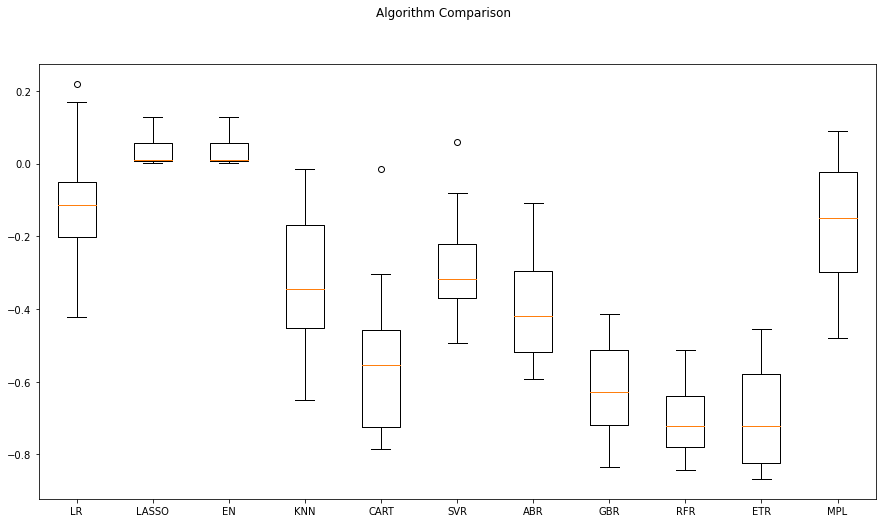

In [55]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [56]:
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Оптимально: %f используя %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) используя: %r" % (mean, stdev, param))

Оптимально: 0.714899 используя {'n_estimators': 150}
0.699469 (0.124710) используя: {'n_estimators': 50}
0.702671 (0.115078) используя: {'n_estimators': 100}
0.714899 (0.103452) используя: {'n_estimators': 150}
0.703236 (0.095940) используя: {'n_estimators': 200}
0.711636 (0.104344) используя: {'n_estimators': 250}
0.710280 (0.097410) используя: {'n_estimators': 300}
0.707389 (0.104787) используя: {'n_estimators': 350}
0.709175 (0.102166) используя: {'n_estimators': 400}


# 7. Обучение модели 

In [57]:
model = RandomForestRegressor(n_estimators = 250)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=250)

# 8. Тестирование модели 

In [58]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.9629682960037163


In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.01668899808563456
0.7703293513573807


[0.21357184 0.02441156 0.01513955 0.04459712 0.02618408 0.24202779
 0.05215916 0.38190891]


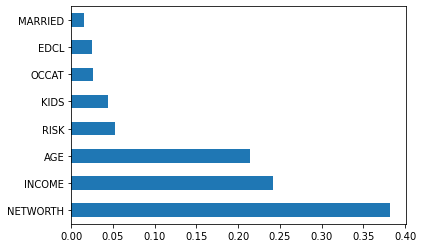

In [60]:
import pandas as pd
import numpy as np
model = RandomForestRegressor(n_estimators= 200,n_jobs=-1)
model.fit(X_train,Y_train)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# 8. Сохранение модели для использования в приложении

In [61]:
from pickle import dump
from pickle import load
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [62]:
loaded_model = load(open(filename, 'rb'))
predictions = loaded_model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(r2_score(Y_validation, predictions))
print(result)

0.7664308256966703
0.016972284120105745
